### HOMEWORK 4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [15]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('HW_data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,64000.0,5.763734,3.507592,1.00,2.00,6.00,9.0000,12.00
history,64000.0,242.085656,256.158608,29.99,64.66,158.11,325.6575,3345.93
used_discount,64000.0,0.551031,0.497393,0.00,0.00,1.00,1.0000,1.00
used_bogo,64000.0,0.549719,0.497526,0.00,0.00,1.00,1.0000,1.00
is_referral,64000.0,0.502250,0.499999,0.00,0.00,1.00,1.0000,1.00
conversion,64000.0,0.146781,0.353890,0.00,0.00,0.00,0.0000,1.00


Пропусков нет.

2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [22]:
df_copy = df.copy()
df_copy.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)
df_copy.loc[df_copy['treatment'] != 'No Offer', 'treatment'] = 1
df_copy.loc[df_copy['treatment'] == 'No Offer', 'treatment'] = 0
df_copy['treatment'] = df_copy['treatment'].astype(np.int8)
df_copy.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [41]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df_copy.drop('target', 1), 
                                                    df_copy['target'], random_state=42)
treat_train = X_train.loc[:, 'treatment']
treat_test = X_test.loc[:, 'treatment']

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

В качестве модели будем использовать CatBoostClassifier, так что преобразование признаков не требуется, передадим в модель признаки used_discount, used_bogo, zip_code, is_referral, channel как категориальные.

Немного поисследуем признаки.

In [24]:
def my_hist(x, figsize=(12, 3)):
    ''' Гистограмма + медиана/мода/средн.арифм. '''
    target_mean = round(x.mean(), 2)
    target_median = x.median()
    target_mode = x.mode()[0]

    plt.figure(figsize=figsize)

    sns.histplot(x, bins=min(20,len(set(x.unique()))))

    plt.axvline(x=[target_mean], label='mean',
                linestyle=':', color="red", linewidth=4)
    plt.axvline(x=[target_median], label='median',
                linestyle='--', color="green", linewidth=4)
    plt.axvline(x=[target_mode], label='mode',
                linestyle='-.', color="brown", linewidth=4)

    plt.title(f'Distribution of {x.name}')
    plt.xlabel(x.name)
    plt.ylabel('Frequency')
    plt.show()

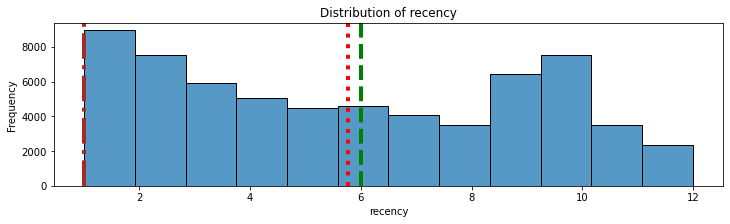

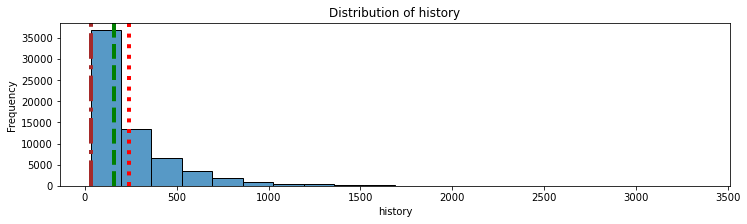

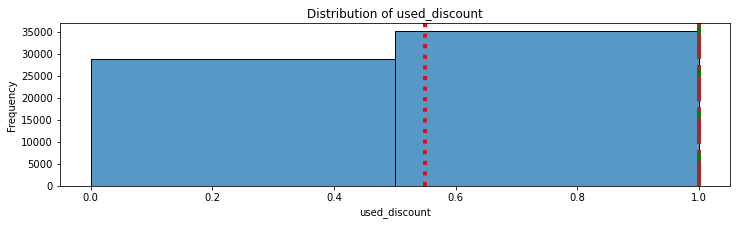

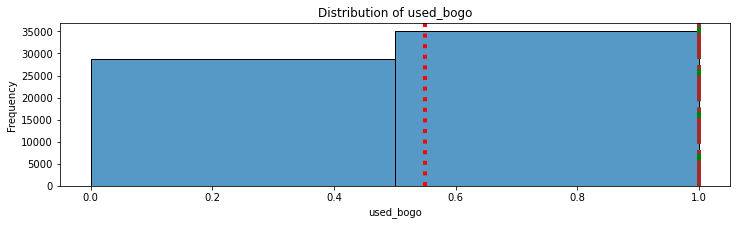

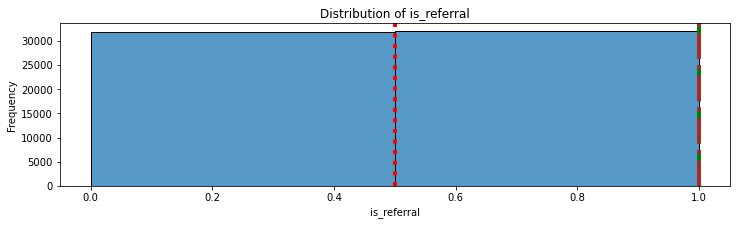

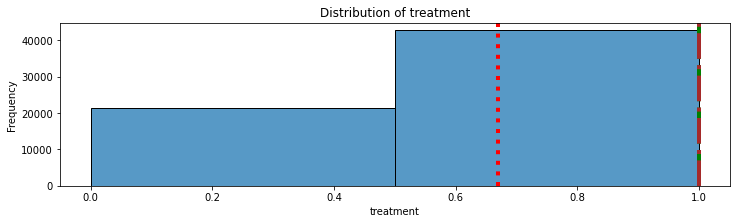

In [25]:
cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'treatment']
for feature in cols:
    my_hist(df_copy[feature])

Криминала не видно.

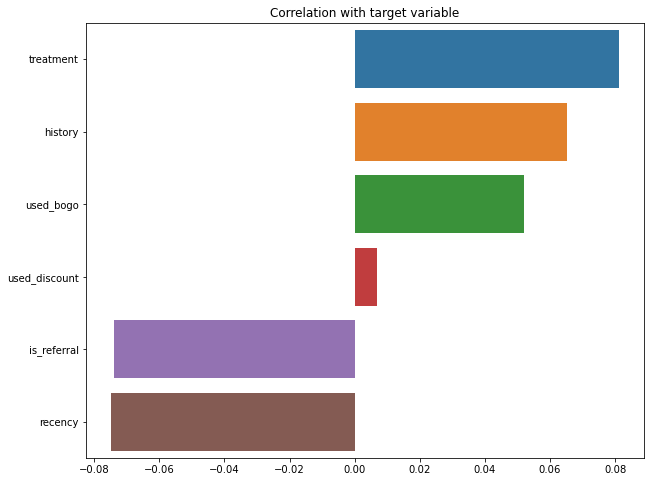

In [26]:
corr_with_target = df_copy.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Особенной линейной корреляции нет.

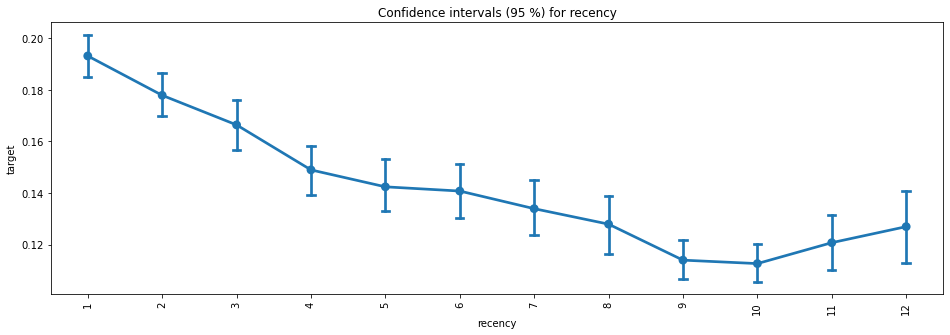

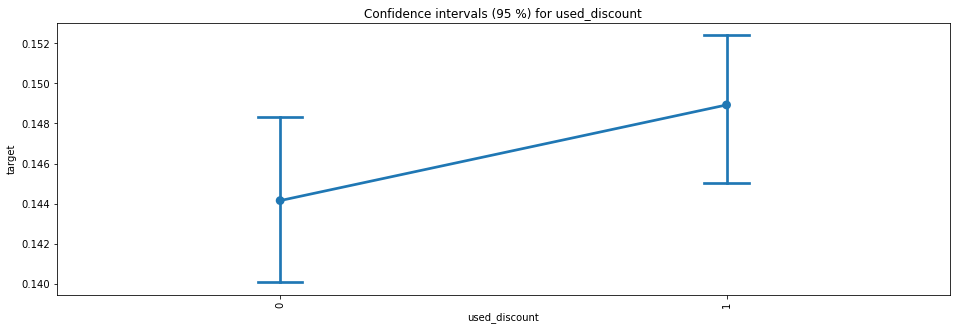

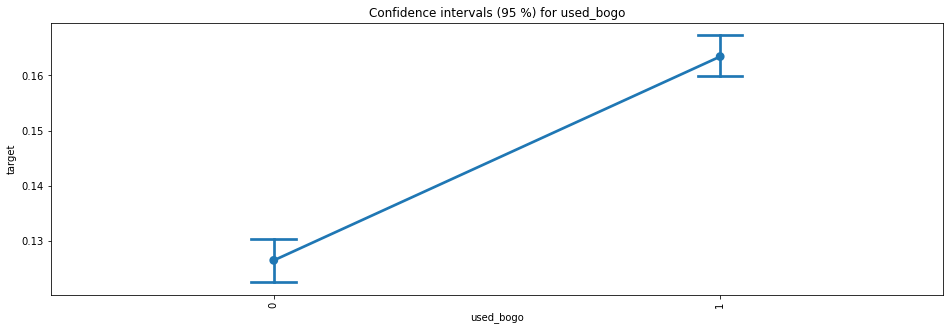

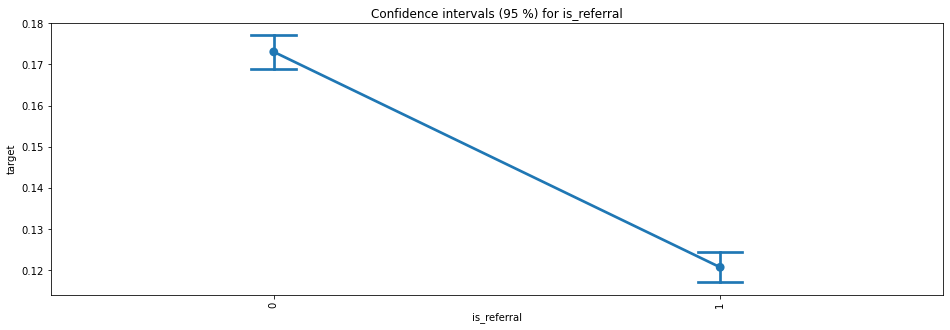

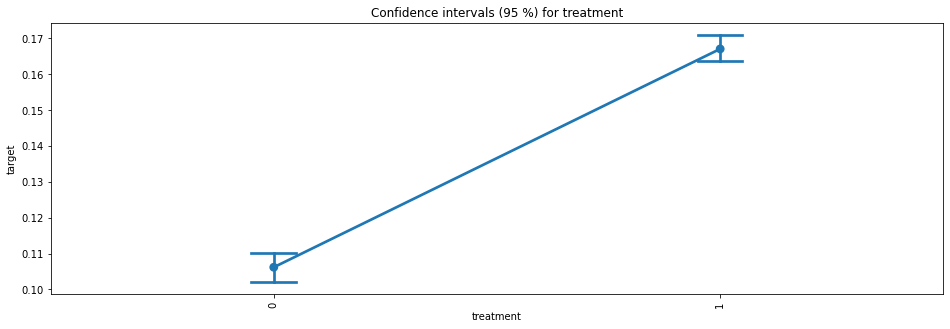

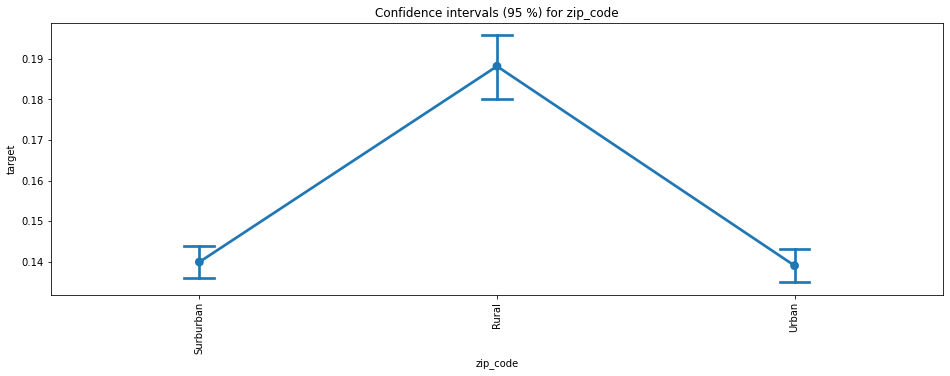

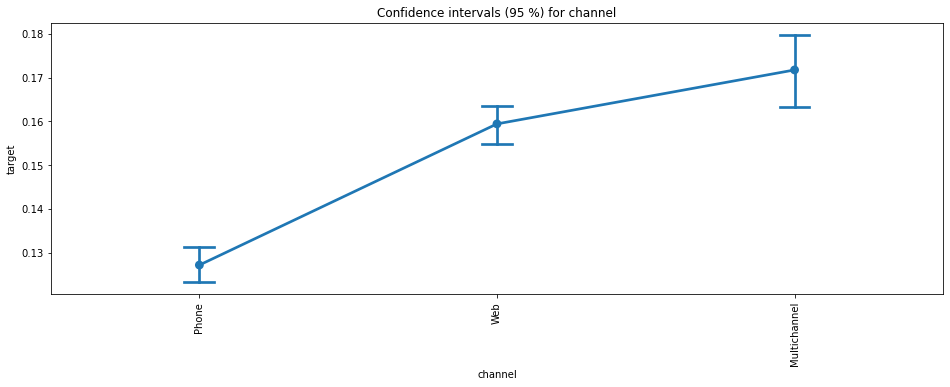

In [29]:
cols = ['recency', 'used_discount', 'used_bogo', 'is_referral', 'treatment', 'zip_code', 'channel']
for feature in cols:
    plt.figure(figsize=(16, 5))

    sns.pointplot(x=feature, y='target', join=True, data=df_copy, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {feature}')
    plt.xticks(rotation=90)
    plt.show()

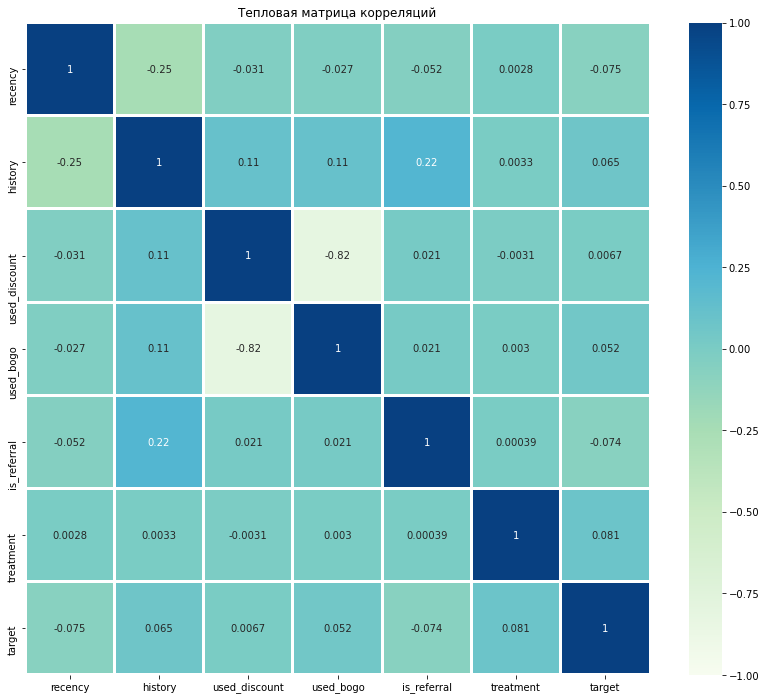

In [31]:
plt.rcParams['figure.figsize'] = (14.0, 12.0)
sns.heatmap(df_copy.corr(), annot = True,fmt='.2g', vmin=-1, vmax=1, center= 0, linewidths = 2, cmap = 'GnBu')
plt.title('Тепловая матрица корреляций')
plt.show()

Есть сильная обратная корреляция у признаков used_discount и used_bogo.

Сгенерируем новый категориальный признак по давности покупки (от 1 до 3 месяцев - категория 1, от 4 до 6 месяцев - категория 2, более 6 месяцев - 3)

In [42]:
X_train['recency_cat'] = 1
X_test['recency_cat'] = 1
X_train.loc[(X_train['recency'] > 3) & (X_train['recency'] <= 6), 'recency_cat'] = 2
X_train.loc[(X_train['recency'] > 6), 'recency_cat'] = 3
X_test.loc[(X_test['recency'] > 3) & (X_test['recency'] <= 6), 'recency_cat'] = 2
X_test.loc[(X_test['recency'] > 6), 'recency_cat'] = 3
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,recency_cat
7517,6,92.45,0,1,Urban,0,Web,0,2
5343,1,796.97,0,1,Rural,1,Multichannel,1,1
35537,7,390.14,0,1,Urban,1,Phone,1,3
63983,2,83.03,0,1,Urban,0,Phone,0,1
45287,10,734.90,1,0,Rural,1,Multichannel,1,3


5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [43]:
cat_features = ['used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'recency_cat']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

**Одна модель с признаком коммуникации**

uplift@10%: 0.1164, uplift@20%: 0.1101


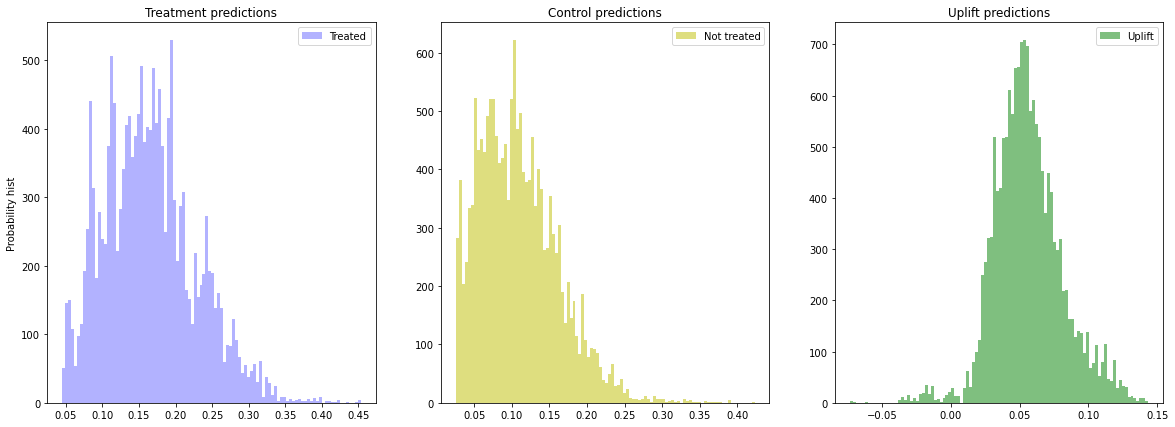

In [44]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {sm_score_10:.4f}, uplift@20%: {sm_score_20:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [45]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.811607
1,treatment,15.991823
2,used_bogo,12.691770
3,recency,11.171673
4,zip_code,11.150434
5,channel,11.071263
6,history,9.197425
7,used_discount,7.900643
8,recency_cat,0.013362


Сгенерированный признак не очень эффективен.

**Трансформация классов**

In [47]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

<ipython-input-47-b14727c484d0>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


**Две независимые модели**

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

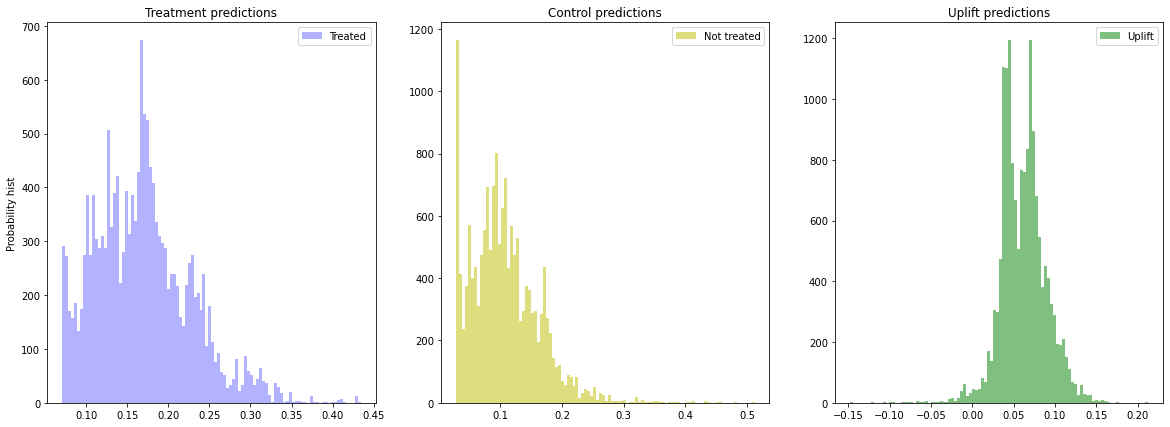

In [48]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

**6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей**

In [49]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.283929,0.234082
0,SoloModel,0.116392,0.110093
2,TwoModels,0.112601,0.098781


Лучше всего отработал подход с трансформацией классов.